## EDA-first-pass Fetch Catalog Technical Challenge - Andrew Byrnes

This notebook serves as a first pass / draft as I explore the challenge questions. It does not neccessiarly contain my final answers, but is for the most part reflective of how I would start to approach these problems. 

### Data Sources
- catalog.db : SQLite file from notebook 1-Data_Prep

### Changes
- 09-01-2022 : Set up notebook
- 09-03-2022 : Worked on question 2
- 09-04-2022 : continued on q2 (validity on products.size word cloud), q3, q4
- 09-05-2022 : exploring another idea for q4, q5, q6
- 09-06-2022 : q7, q2 (Integrity)
- 09-07-2022 : q8, q9
- 09-08-2022 : completed EDA


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from os import path
from datetime import datetime
import sqlite3
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import re

/home/byrnes/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### File Locations

In [3]:
db_path = Path.cwd() / "data" / "processed" / "catalog.db"
fetch_logo = Path.cwd() / "data" / "raw" / "fetch.jpg"

### Formatting

In [4]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows')

### Catalog.db schema  

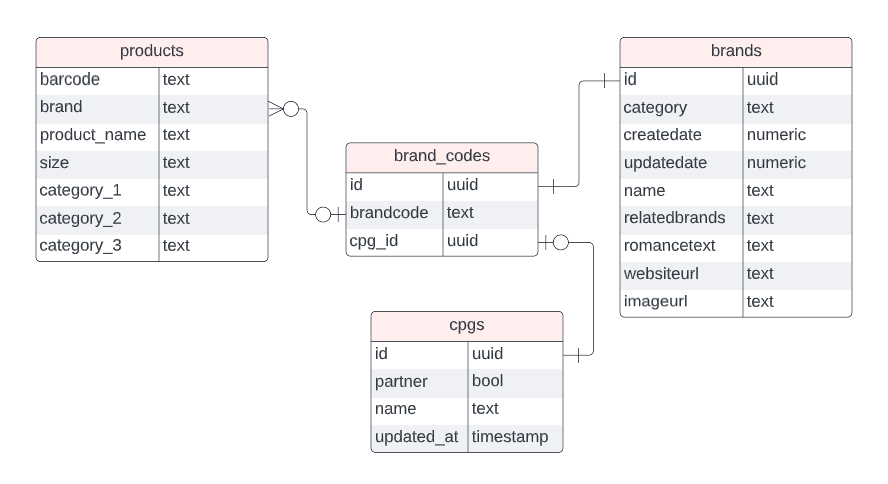

### General questions

#### 1) What are your general observations about the quality & completeness of the data included in this challenge?

#### 2) Please develop 1-2 metrics that grade the quality of data presented in one of these tables. The `products` or `brands` tables are a good candidate for this.  

~**to do**:~ Completeness: % records with null % of records with null values in at least 1,2,3 fields
              - table info - column names and count of records with null value, and total %
              
column names | null count | null %

There are X% records with at least 1 null field
There are X% records with at least 2 null fields
There are X% records with at least 3 null fields

~**to do**~: Integrity: An appropriate metric for data integrity would be the number of orphan records present in a database.       
Broken links: % of records in table that don't match a join

**to do**: Validity: percentage of records in which all values are valid - does the content conform to expectations?  

**to do**: products.barcodes - do all values conform to https://en.wikipedia.org/wiki/Universal_Product_Code#Variations  
check that everything is numeric, group by length and category 1 for spot check  

~**to do**~ : products.size: word cloud to spot check what's there


*ref:  
word clouds: https://www.precisely.com/blog/data-quality/does-your-data-measure-up-assess-data-quality  
phrases instead of words - multi word: https://stackoverflow.com/questions/58286251/how-can-i-group-multi-word-terms-when-creating-a-python-wordcloud*

In [5]:
def completeness_summary(db_path, table_name):

    query = f"""
        select 
            *
        from
            {table_name}
    """

    #execute the above query and save results to dataframe 
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query(query, conn)
    conn.close()

    # create summary dataframes to be populated after translations
    columns_summary_df = pd.DataFrame()
    records_summary_df = pd.DataFrame()
    # variable for % calculations
    df_records = len(df.index)


    # convert values to boolean based on if NaN(null), sum across index axis 
    null_count_fields = df.isnull().sum(0)

    # add the index values (table column names) to the first column of columns_summary_df
    columns_summary_df['columns'] = pd.Series(null_count_fields.index.values.tolist())

    # add the counts of NaN(null) values to columns_summary_df
    columns_summary_df['null_values'] = pd.Series(null_count_fields.tolist())

    # add % of null fields in each column to columns_summary_df
    columns_summary_df['percent_null'] = columns_summary_df.null_values / df_records * 100
    columns_summary_df['percent_null'] = columns_summary_df['percent_null'].round(decimals = 1)

    # sort columns_summary_df by null_values decending 
    columns_summary_df = columns_summary_df.sort_values(by=['null_values'], ascending=False)


    # convert values to boolean based on if NaN(null), sum across columns axis 
    null_count_columns = df.isnull().sum(1)

    records_w_null = {
        0:0,
        1:0,
        2:0,
        3:0,
        4:0,
        5:0,
        6:0,
        7:0,
        8:0,
        9:0,
        10:0
    }
    
    
    # # populate records_w_null dict
    for key, value in records_w_null.items():
        for r in null_count_columns:
            if key == 0:
                if r == 0:
                    value += 1
            elif r >= key:
                value += 1
        records_w_null.update({key:value})

    # add the keys from records_w_null to the first column of records_summary_df
    col1 = []
    for key in records_w_null.keys():
        if key == 0:
            col1.append("0")
        else:
            col1.append(f"{key} or more")

    records_summary_df.insert(0,'fields_with_null_values',col1)           

    # add the values from records_w_null to the second column of records_summary_df
    records_summary_df.insert(1,'record_count',records_w_null.values()) 

    # add % of records with  in each column to columns_summary_df
    records_summary_df['record_percent'] = records_summary_df.record_count / df_records * 100
    records_summary_df['record_percent'] = records_summary_df['record_percent'].round(decimals = 1)


    # print summary report
    print(42*"#"+"\n"
        +f"""The {table_name} table has {df_records} records."""+2*"\n"
        +"The following summarizes the completeness of the record set by describing how many records"+"\n"
        "contain null values:"+2*"\n"
        +records_summary_df.to_string(index=False)+2*"\n"
        +"The following summarizes  total and % of null values in every column:"""+2*"\n"
        +columns_summary_df.to_string(index=False)+2*"\n"
        ++42*"#"+"\n"
         )

In [6]:
completeness_summary(db_path, "brands")

##########################################
The brands table has 262 records.

The following summarizes the completeness of the record set by describing how many records
contain null values:

fields_with_null_values  record_count  record_percent
                      0            12             4.6
              1 or more           250            95.4
              2 or more           150            57.3
              3 or more           110            42.0
              4 or more            51            19.5
              5 or more            27            10.3
              6 or more             0             0.0
              7 or more             0             0.0
              8 or more             0             0.0
              9 or more             0             0.0
             10 or more             0             0.0

The following summarizes  total and % of null values in every column:

      columns  null_values  percent_null
relatedbrands          245          93.5
     im

In [8]:
completeness_summary(db_path, "brand_codes")

##########################################
The brand_codes table has 263 records.

The following summarizes the completeness of the record set by describing how many records
contain null values:

fields_with_null_values  record_count  record_percent
                      0           260            98.9
              1 or more             3             1.1
              2 or more             0             0.0
              3 or more             0             0.0
              4 or more             0             0.0
              5 or more             0             0.0
              6 or more             0             0.0
              7 or more             0             0.0
              8 or more             0             0.0
              9 or more             0             0.0
             10 or more             0             0.0

The following summarizes  total and % of null values in every column:

  columns  null_values  percent_null
brandcode            3           1.1
       id 

In [9]:
completeness_summary(db_path, "cpgs")

##########################################
The cpgs table has 300 records.

The following summarizes the completeness of the record set by describing how many records
contain null values:

fields_with_null_values  record_count  record_percent
                      0           256            85.3
              1 or more            44            14.7
              2 or more             0             0.0
              3 or more             0             0.0
              4 or more             0             0.0
              5 or more             0             0.0
              6 or more             0             0.0
              7 or more             0             0.0
              8 or more             0             0.0
              9 or more             0             0.0
             10 or more             0             0.0

The following summarizes  total and % of null values in every column:

   columns  null_values  percent_null
   partner           44          14.7
        id     

In [10]:
completeness_summary(db_path, "products")

##########################################
The products table has 1500 records.

The following summarizes the completeness of the record set by describing how many records
contain null values:

fields_with_null_values  record_count  record_percent
                      0          1174            78.3
              1 or more           326            21.7
              2 or more             0             0.0
              3 or more             0             0.0
              4 or more             0             0.0
              5 or more             0             0.0
              6 or more             0             0.0
              7 or more             0             0.0
              8 or more             0             0.0
              9 or more             0             0.0
             10 or more             0             0.0

The following summarizes  total and % of null values in every column:

     columns  null_values  percent_null
        size          324          21.6
  cate

In [8]:
query = f"""
        select 
            product_name
            , category_1
        from
            products
        where
            size is null
    """
#execute the above query and save results to dataframe 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()
df

product_name  \
0                                                                                                        TERRO READY-TO-USE LIQUID ANT KILLER, 2 OZ   
1                                                                                                                 SKIN PROTECTANT ADVANCED SCAR GEL   
2                                                                 LIPTON STRAWBERRY WTRMELON ICED HERBAL TEA TEA CAFFEINE FREE 2 OZ - 0041000004382   
3                                                                    HUGGIES LITTLE MOVERS SIZE SIX DISPOSABLE DIAPER BAG DISNEY TRADEMARK MULTIPLE   
4                                                       PILLSBURY TOASTER STRUDEL FROZEN SWEET CREAM CHEESE TOASTER STRUDEL 12.5 OZ - 0018000418271   
5                                                                                 AMP ENERGY ORGANIC GRAPE ENERGY DRINK 12 FLUID OUNCE ALUMINUM CAN   
6                                                                                             MARINELA GANSITO CHERRY SNACK CAKES, 8 COUNT, 1411 OZ   
7                                                                                                    CVS HEALTH LICE SOLUTION KIT, MAXIMUM STRENGTH   
8                                                                                            COPPERTONE SPORT VALUE SPF 50 SUNSCREEN LOTION, 9.1 OZ   
9                                                                                   BROMLEY ESTATE BLEND TEA BAGS, 12 PACKS OF 100CT (TOTAL 1200CT)   
10                                                                                                                            CREAMY ACNE FACE WASH   
11                                                                                                                       DOVE SHEA BUTTER SOAP 6 CT   
12                                                                                        BREAKOUT FREE FACE LOTION BROAD SPECTRUM SPF 30 SUNSCREEN   
13                                                        DEEP PENETRATING AND ODOR FREE CAPSAICIN 01 ARTHRITIS PAIN RELIEF TOPICAL ANALGESIC CREAM   
14                                                          MEDLINE CURAD POWDER-FREE STRETCH SYNTHETIC VINYL EXAM GLOVES OFF-WHITE, 100CT, X-LARGE   
15                                                                                                               PRO LT SOUP ITALIAN STYLE MEATBALL   
16                                                              MARINELA GANSITO CHOCOLATE COVERED CREME & STRAWBERRY FILLED COOKIES TUBE, 10 COUNT   
17                                                                                           SMARTFOOD RTE POPCORN SPICY JALAPENO RANCH BAG .875 OZ   
18                                                                TROPICANA RASPBERRY LEMONADE DRINK NT FRM CNCNTRT PSTRZ PLASTIC BOTTLE 1 CT 12 OZ   
19                                                                                            JOHNSON & JOHNSON RED CROSS ALL PURPOSE FIRST AID KIT   
20                                                                                         HUGGIES LITTLE MOVERS DISPOSABLE DIAPER SIZE 5 112 COUNT   
21                                                                                            NAKED REGULAR PINEAPPL KL CCNT WTR JUICE 1 CT 16.9 OZ   
22                                                                                                                    30.00OZ VARIETY PACK 30 COUNT   
23                                                                                                                       Q-TIPS COTTON SWABS 750 CT   
24                                                                                    LIPTON GREEN TEA BAGS SUPERFRUIT MIXED BERRY, 6 PACKS OF 20CT   
25                                                                                                   DOVE SENSITIVE SKIN UNSCENTED BEAUTY BAR 20 CT   
26                                                        

In [7]:
completeness_summary(db_path, "related_brands")

##########################################
The related_brands table has 48 records.

The following summarizes the completeness of the record set by describing how many records
contain null values:

fields_with_null_values  record_count  record_percent
                      0            48           100.0
              1 or more             0             0.0
              2 or more             0             0.0
              3 or more             0             0.0
              4 or more             0             0.0
              5 or more             0             0.0
              6 or more             0             0.0
              7 or more             0             0.0
              8 or more             0             0.0
              9 or more             0             0.0
             10 or more             0             0.0

The following summarizes  total and % of null values in every column:

     columns  null_values  percent_null
       brand            0           0.0
re

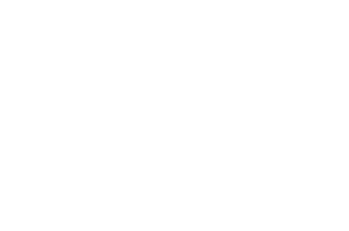

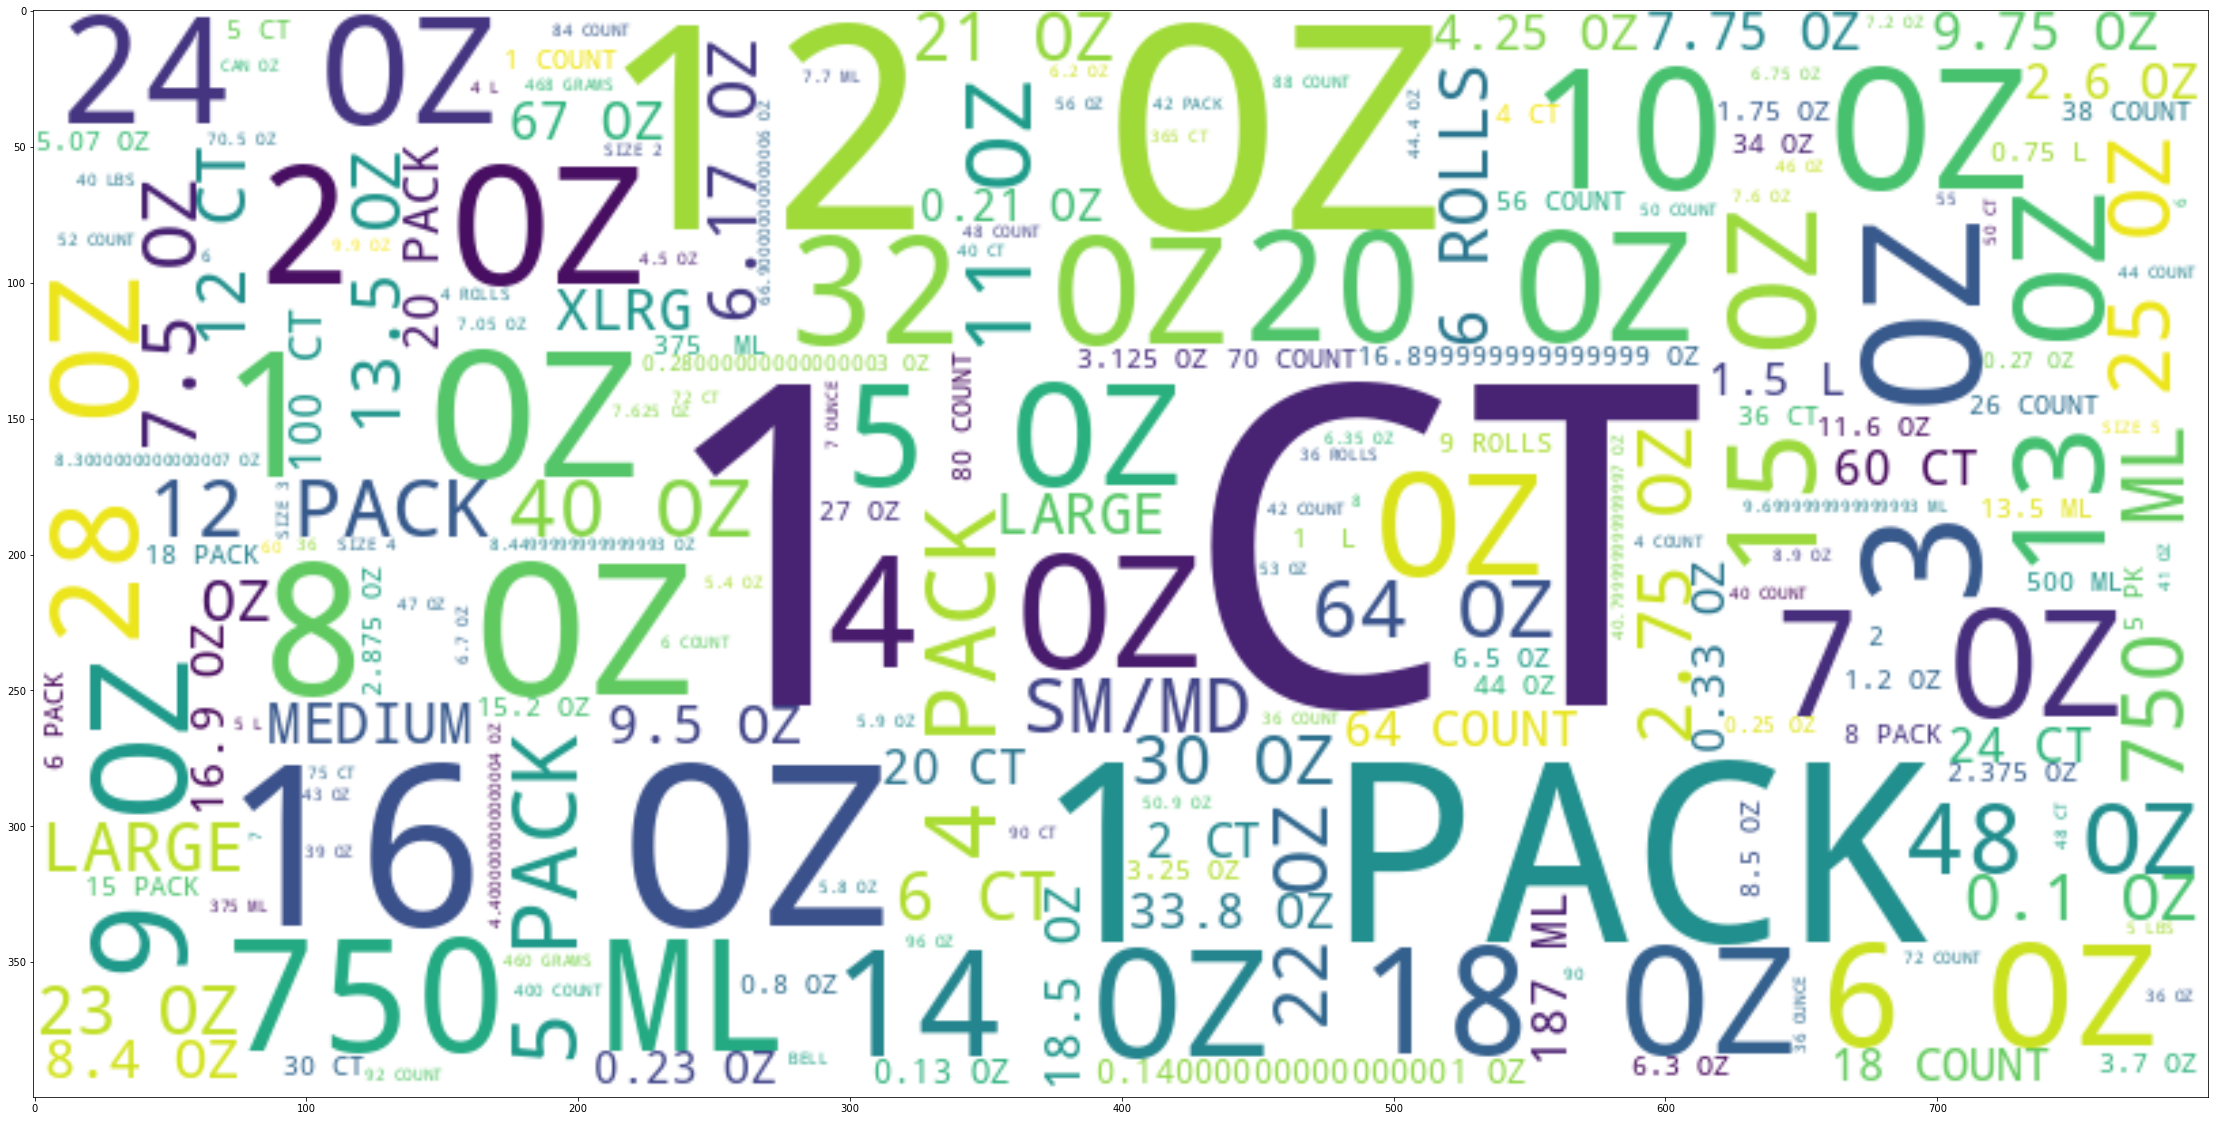

Top 20 values present in products.size and the count of records:

  size  records
  None      324
  1 CT      203
 12 OZ       56
             47
1 PACK       42
 16 OZ       34
  8 OZ       21
  1 OZ       20
 10 OZ       18
  3 OZ       17
  2 OZ       17
750 ML       16
  4 OZ       16
 20 OZ       15
  7 OZ       14
 32 OZ       14
 24 OZ       14
 18 OZ       14
 14 OZ       14
  6 OZ       13


In [11]:
# visualizing the values in products.size

query = f"""
    select
        size,
        count(*) as records
    from
        products
    group by size
    order by records desc
    """

#execute the queries above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

# convert df to dict for word cloud using phrases, get ride of nulls(None) values
phrases_dict = df.dropna().set_index('size').to_dict()['records']



# generate wordcloud
wordcloud = WordCloud(background_color="white", width=800, height=400).generate_from_frequencies(phrases_dict)

# Display the generated image with matplotlib:

plt.axis("off")
plt.figure( figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

print("Top 20 values present in products.size and the count of records:"+2*"\n"+df.head(20).to_string(index=False))




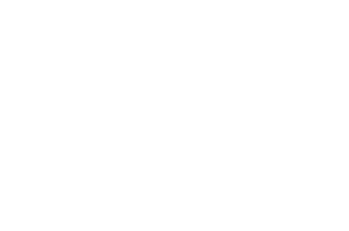

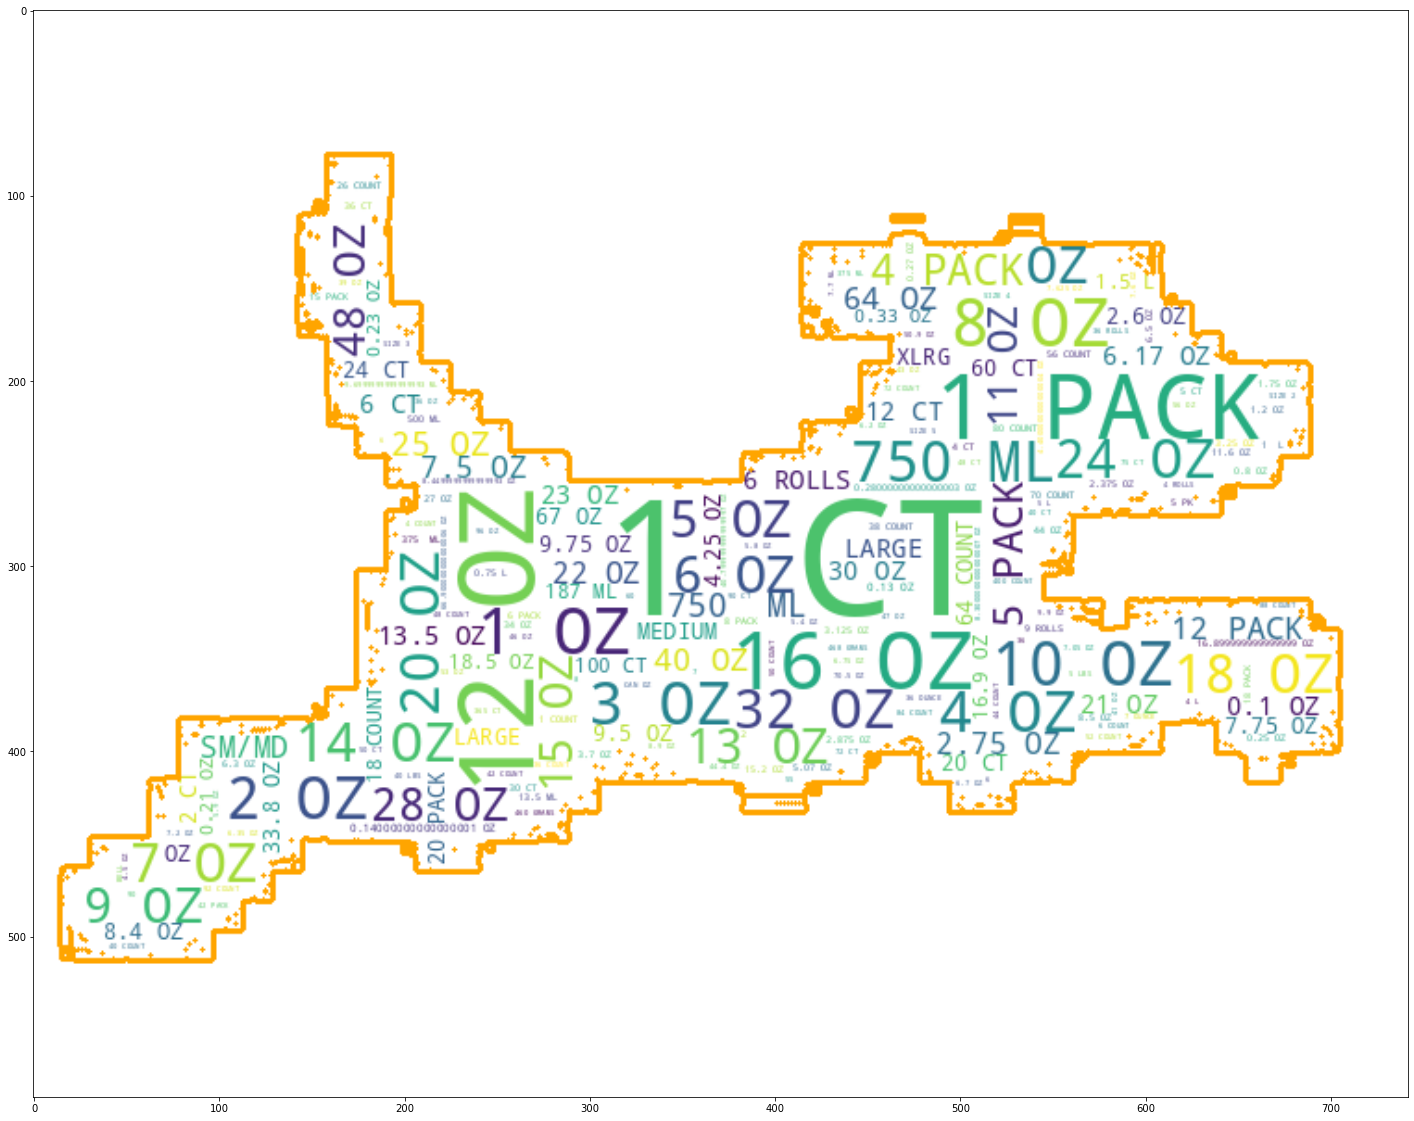

In [15]:
# converting jpg image to a numpy array
fetch_mask = np.array(Image.open(fetch_logo))

wordcloud_fetch = WordCloud(background_color="white", width=800, height=400, mask=fetch_mask, contour_width=3, contour_color='orange').generate_from_frequencies(phrases_dict)

plt.axis("off")
plt.figure( figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud_fetch, interpolation='bilinear')
plt.show()

In [10]:
# Integrity - how many products are orphaned by not joining on p.brand <-> bc.brandcode?
query = f"""
    with p_to_bc as 
        (
        select
            "products.brand (many or zero) TO (zero or one) brand_codes.brandcode" as join_type,
            count(p_brand) as total_joinable_records_left_table,
            count(bc_brandcode) as records_matched,
            count(p_brand) - count(bc_brandcode) as records_orphaned,
            round(cast(count(p_brand) - count(bc_brandcode) as REAL) / count(p_brand) * 100, 2) as percentage_orphaned
        from
            ( 
            select
                p.brand as p_brand,
                bc.brandcode as bc_brandcode 
            from
                products p
                left join brand_codes bc on bc.brandcode = p.brand         
            )           
        ),
        
        bc_to_p as
        (
        select
            "brand_codes.brandcode (zero or one) TO (many or zero) products.brand" as join_type,
            count(bc_brandcode) as total_joinable_records_left_table,
            count(p_brand) as records_matched,
            count(bc_brandcode) - count(p_brand) as records_orphaned,
            round(cast(count(bc_brandcode) - count(p_brand) as REAL) / count(bc_brandcode) * 100, 2) as percentage_orphaned
        from
            (
            select
                bc.brandcode as bc_brandcode,
                p.brand as p_brand
            from
                brand_codes bc
                -- need just the distinct brands from product table for comparison
                left join (
                            select
                                distinct brand
                            from
                                products
                            ) p on p.brand = bc.brandcode
            )
        ),
        
        bc_to_b as
        (
        select
            "brand_codes.id (one) TO (one) brands.id" as join_type,
            count(bc.id) as total_joinable_records_left_table,
            count(b.id) as records_matched,
            count(bc.id) - count(b.id) as records_orphaned,
            round(cast(count(bc.id) - count(b.id) as REAL) / count(bc.id) * 100, 2) as percentage_orphaned
        from
            brand_codes bc
            left join brands b on b.id = bc.id
        ),
        
        b_to_bc as
        (
        select
            "brands.id (one) TO (one) brand_codes.id" as join_type,
            count(b.id) as total_joinable_records_left_table,
            count(bc.id) as records_matched,
            count(b.id) - count(bc.id) as records_orphaned,
            round(cast(count(b.id) - count(bc.id) as REAL) / count(b.id) * 100, 2) as percentage_orphaned
        from
            brands b
            left join brand_codes bc on bc.id = b.id
        ),
        
        bc_to_c as
        (
        select
            "brand_codes.cpg_id (one or zero) TO (one) cpgs.id" as join_type,
            count(bc.cpg_id) as total_joinable_records_left_table,
            count(c.id) as records_matched,
            count(bc.cpg_id) - count(c.id) as records_orphaned,
            round(cast(count(bc.cpg_id) - count(c.id) as REAL) / count(bc.cpg_id) * 100, 2) as percentage_orphaned
        from
            brand_codes bc
            left join cpgs c on c.id = bc.cpg_id
        ),
        
        c_to_bc as
        (
        select
            "cpgs.id (one) TO (one or zero) brand_codes.cpg_id" as join_type,
            count(c.id) as total_joinable_records_left_table,
            count(bc.cpg_id) as records_matched,
            count(c.id) - count(bc.cpg_id) as records_orphaned,
            round(cast(count(c.id) - count(bc.cpg_id) as REAL) / count(c.id) * 100, 2) as percentage_orphaned
        from
            cpgs c
            left join brand_codes bc on bc.cpg_id = c.id
        )
        
        select * from p_to_bc
        UNION
        select * from bc_to_p
        UNION
        select * from bc_to_b
        UNION
        select * from b_to_bc
        UNION
        select * from bc_to_c
        UNION
        select * from c_to_bc
        order by percentage_orphaned desc
    """
#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

df




join_type  \
0  products.brand (many or zero) TO (zero or one) brand_codes.brandcode   
1  brand_codes.brandcode (zero or one) TO (many or zero) products.brand   
2                     cpgs.id (one) TO (one or zero) brand_codes.cpg_id   
3                               brand_codes.id (one) TO (one) brands.id   
4                     brand_codes.cpg_id (one or zero) TO (one) cpgs.id   
5                               brands.id (one) TO (one) brand_codes.id   

   total_joinable_records_left_table  records_matched  records_orphaned  \
0                               1500              231              1269   
1                                260               56               204   
2                                492              263               229   
3                                263              262                 1   
4                                263              263                 0   
5                                262              262                 0   

   percentage_orphaned  
0                84.60  
1                78.46  
2                46.54  
3                 0.38  
4                 0.00  
5                 0.00

### Products-related questions  
*The following few questions can be solved by looking solely at the products table.*  

#### 3) What are the most popular category-1, -2 & -3 combinations from the `products` table?  
The most popular 3-level combinations is COLOR COSMETICS:LIP:LIPSTICK with 48 records representing 3.2% of total products.  
This is followed by NAIL:NAIL:ENAMEL with 36 records/2.4% and PERSONAL WASH:BODY WASH:BODY WASH X ACNE with 33 records/2.2%. The rest of the 3-level combinations rank under 2%.   

#### Does that ranking change if you only include the top 2 levels of categories? 
Yes. COLOR COSMETICS:LIP ranks 3rd of the top 2-level combinations at 75/5.8% (COSMETICS:LIP:LIPSTICK was first of 3-level combinations).  
NAIL:NAIL drops to 6th representing 2.4% (NAIL:NAIL:ENAMEL was second of 3-level combinations).  
PERSONAL WASH:BODY WASH drops to 7th representing 2.3% (PERSONAL WASH:BODY WASH:BODY WASH X ACNE was third of 3-level combinations).  
  
The most popular 2-level combinations is DAILY HAIR CARE:WASH & CARE with 87 records representing 5.8% of total records. Followed by FLNA:SALTY SNACKS with 79 records/5.3% and COLOR COSMETICS:LIP with 75 records/5.0%. The rest of the 2-level combinations rank under 5%.

At quick glance, personal care products appear to dominate the top 10 of both 3-level and 2-level granularities.  

#### What if you only include the top level?
When gruoping by only category_1, COLOR COSMETICS ranks first by far with 188 records representing 12.5% of total products.  
LRB enters the top 5 rankings at second with 125 records/8.3%.  
DAILY HAIR CARE remains popular at third with 112 records/7.5%.

Categories realted to personal care still remain very popular when bucketing at this granularity. 

In [16]:
query_123 = f"""
    select 
        category_1 || ':' || category_2 || ':' || category_3 as category_123
        , count(*) as records
    from
        products
    group by 1
    order by 2 desc
    """
query_12 = f"""
    select 
        category_1 || ':' || category_2 as category_12
        , count(*) as records
    from
        products
    group by 1
    order by 2 desc
    """
query_1 = f"""
    select 
        category_1 as category_1
        , count(*) as records
    from
        products
    group by 1
    order by 2 desc
    """

#execute the queries above and save results to dataframes 
conn = sqlite3.connect(db_path)
df_123 = pd.read_sql_query(query_123, conn)
df_12 = pd.read_sql_query(query_12, conn)
df_1 = pd.read_sql_query(query_1, conn)
conn.close()

#add a % column to dataframes
df_123_sum_records = df_123['records'].sum()
df_123['record_percent'] = df_123['records'] / df_123_sum_records * 100
df_123['record_percent'] = df_123['record_percent'].round(decimals = 1)

df_12_sum_records = df_12['records'].sum()
df_12['record_percent'] = df_12['records'] / df_12_sum_records * 100
df_12['record_percent'] = df_12['record_percent'].round(decimals = 1)

df_1_sum_records = df_1['records'].sum()
df_1['record_percent'] = df_1['records'] / df_123_sum_records * 100
df_1['record_percent'] = df_1['record_percent'].round(decimals = 1)

print(df_123.head(20).to_string(index=False)+"\n")
print(df_12.head(20).to_string(index=False)+"\n")      
print(df_1.head(20).to_string(index=False)+"\n")      

                                           category_123  records  record_percent
                           COLOR COSMETICS:LIP:LIPSTICK       48             3.2
                                       NAIL:NAIL:ENAMEL       36             2.4
               PERSONAL WASH:BODY WASH:BODY WASH X ACNE       33             2.2
 DAILY HAIR CARE:WASH & CARE:REGULAR/BASIC CONDITIONERS       26             1.7
      WOMENS HAIR COLOR:BASIC PERMANENT:BASIC PERMANENT       24             1.6
                                            LRB:CSD:CSD       23             1.5
                         COLOR COSMETICS:EYE:EYE SHADOW       23             1.5
                                   LRB:SPORTS DRINK:NCB       22             1.5
              PERSONAL WASH:BAR SOAP:BAR SOAP INCL FACE       20             1.3
                       FLNA:SALTY SNACKS:TORTILLA CHIPS       20             1.3
                          COLOR COSMETICS:LIP:LIP GLOSS       19             1.3
                            

#### 4) How many products appear to have a mis-match between the size as listed in the size field and the text in the product field?


Notes: check out - https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
-seems like Partial String Similarity will be best

In [22]:
#query to pull size and product_name for comparison, exclude the 324 size is null records
query = f"""
    select 
        size,
        product_name
    from
        products
    where 
        size is not null
        and size <> ' '
    """
#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()


# commenting the following out, and re-running - will do ratio check after adding the extracted_size column
# # compare size and product_name using fuzzywuzzy partial_ratio
# partial_ratio_scores = []

# for index, row in df.iterrows():
#     score = fuzz.partial_ratio(row['size'], row['product_name'])
#     partial_ratio_scores.append(score)
    
# # add partial_ratio scores as a column on the dataframe
# df['partial_ratio_score'] = partial_ratio_scores

# pd.set_option('display.max_rows', None)
# filter = df['partial_ratio_score']<100
# df.sort_values('partial_ratio_score', ascending=False).where(filter).dropna()




Idea: create a set of size words from the size column. things like OZ, Large, ML, CT. Create a new product_name column that strips out everytihng except numbers and words in the size list. Then fuzzy match against that.
This same extract from product name could be used in the next question.

In [23]:
alpha_sizes = pd.DataFrame()
alpha_sizes['size'] = df['size']

just_alpha = []

# create a list of the size column without any numbers
for index, row in alpha_sizes.iterrows():
    alphas = re.sub(r'[^A-Za-z]', '', row['size'])
    just_alpha.append(alphas)

# only unique values
just_alpha = list(set(just_alpha))
# print(just_alpha)

# remove the ''
just_alpha.remove('')
# print(just_alpha)

# https://stackoverflow.com/questions/33406313/how-to-match-any-string-from-a-list-of-strings-in-regular-expressions-in-python
# x = "AIR WICK DBL FRS SCENTED OIL REFILL CCTS FLWR WRM BRZ BTL 1.34 FL OZ BOX W/ELCT WRMR 006233888187"

#find any occurance of the just_alpha strings in a string and keep
# print(re.findall(r"(?=(\b" + '\\b|\\b'.join(just_alpha) + r"\b))", x))

#find any numbers and decials in a string and keep
# print(re.sub('[^0-9.]', '', x))

#remove matchs that are between 8 and 12 digits
# print(re.sub('\d{6,12}', '', x))

#process - remove upc like numbers, pull out numbers, pull out just alpha matchs, concat with space, add to df to comapre to size
product_name_extracts = pd.DataFrame()

product_name_extracts['product_name'] = df['product_name']

# make a list of product_names without upcs and add column to product_name_extracts
remove_upc = []
for index, row in product_name_extracts.iterrows():
    no_upc = re.sub('\d{6,20}', '', row['product_name'])
    remove_upc.append(no_upc)
    
product_name_extracts['no_upc'] = remove_upc


# make a list of no_upc with only numbers and decimals and add column to product_name_extracts
nums_deci = []
for index, row in product_name_extracts.iterrows():
    num_deci = re.sub('[^0-9.]', '', row['no_upc'])
    nums_deci.append(num_deci)
    
product_name_extracts['nums_deci'] = nums_deci

# make a list of no_upc with only matchs from the just_alpha list and add column to product_name_extracts
alpha_sizes = []
for index, row in product_name_extracts.iterrows():
    # use search instead of findall so it stops after the first match and appends a string not list
    alpha_size = re.search(r"(?=(\b" + '\\b|\\b'.join(just_alpha) + r"\b))", row['no_upc'])
    if alpha_size is None:
        alpha_sizes.append(alpha_size)
    else:
        alpha_sizes.append(alpha_size.group(1))

product_name_extracts['alpha_sizes'] = alpha_sizes

# create new product_name_extracts column (size_extracted) that concats nums_deci + ' ' + alpha_sizes and add to df
product_name_extracts['size_extracted'] = product_name_extracts['nums_deci'] + ' ' + product_name_extracts['alpha_sizes']

# add size_extracted to df
df['size_extracted'] = product_name_extracts['size_extracted']

# drop nulls from dataframe
df.dropna(inplace=True)
# compare og size and extracted_size using fuzzywuzzy fuzz.ratio
fuzzy_scores = []

for index, row in df.iterrows():
    score = fuzz.ratio(row['size'], row['size_extracted'])
    fuzzy_scores.append(score)
    
# add partial_ratio scores as a column on the dataframe
df['fuzzy_score'] = fuzzy_scores

pd.set_option('display.max_rows', None)
filter = df['fuzzy_score']<101
df.sort_values('fuzzy_score', ascending=False).where(filter).dropna()


size  \
812                    8 OZ   
751                   24 OZ   
795                   16 OZ   
789                   12 OZ   
787                    6 OZ   
315                    9 OZ   
782                    7 OZ   
780                   48 OZ   
320                  7.2 OZ   
322                   16 OZ   
775                   15 OZ   
325                   48 OZ   
762                   12 OZ   
761                   32 OZ   
337                   16 OZ   
756                52 COUNT   
749                  5.9 OZ   
904                   18 OZ   
745                    5 OZ   
344                   10 OZ   
740                   48 OZ   
737                   10 OZ   
731                    7 OZ   
726                    8 OZ   
723             250 PACKETS   
361                   12 OZ   
721                   16 OZ   
719                   15 OZ   
367                  8.4 OZ   
713                   12 OZ   
377                    8 OZ   
705                    2 OZ   
802                24 COUNT   
305                   24 OZ   
303                 3.25 OZ   
300                   24 OZ   
200                12 COUNT   
901                   12 OZ   
897                    8 OZ   
217                   18 OZ   
221                    4 OZ   
866                 6.75 OZ   
241                    6 OZ   
243                   13 OZ   
861                   16 OZ   
247                    7 OZ   
860                    2 OZ   
847                   32 OZ   
845                   32 OZ   
843                   12 OZ   
829                    1 CF   
822                   10 OZ   
268                    1 CT   
272                   30 OZ   
817                    9 OZ   
281                   13 OZ   
810                   44 OZ   
287                   16 OZ   
288                 2.64 OZ   
289                 44.4 OZ   
807                   16 OZ   
294                 15.8 OZ   
295                   40 OZ   
296                   24 OZ   
804                   27 OZ   
380                   16 OZ   
703                18 COUNT   
702                    2 OZ   
476                    6 OZ   
483                    3 OZ   
489                    4 OZ   
491                   56 OZ   
493                   44 OZ   
495                   12 OZ   
502                    6 OZ   
608                   16 OZ   
513                48 COUNT   
591                  4 PACK   
518                   23 OZ   
519                16 COUNT   
520                   13 OZ   
522                    4 OZ   
585                   21 OZ   
524                   12 OZ   
525                  6.7 OZ   
583                   20 OZ   
582                    9 OZ   
581                    1 CT   
578                22 COUNT   
536                   64 OZ   
576                   12 OZ   
571                   39 OZ   
570                   48 OZ   
564                   18 OZ   
562                   12 OZ   
560                  152 OZ   
553                  3.1 OZ   
554                    1 OZ   
482                   48 OZ   
616                  4 PACK   
699                   10 OZ   
617               15.625 OZ   
390                   11 OZ   
695                13.25 OZ   
688                34 COUNT   
400                 1 LITER   
401               240 COUNT   
405                 6 COUNT   
681                   15 OZ   
411                    8 OZ   
414                   34 OZ   
418                   15 OZ   
422                    9 OZ   
676                    3 OZ   
672                    3 OZ   
670                   15 OZ   
664                  1.2 OZ   
432                    1 OZ   
656                    4 OZ   
651                   21 OZ   
445                   20 CT   
641                  4 PACK   
635                   12 OZ   
634                   22 OZ   
625                   13 OZ   
458                    2 CT   
622                  4 PACK   
621                   25 OZ   
462                 13.5

take 2 - I think I can find the size alpha strings and extract the proceding numbers
ref:  
https://stackoverflow.com/questions/64801043/use-regular-expression-to-extract-numbers-before-specific-words  
https://stackoverflow.com/questions/49561092/regex-to-match-preceding-word  
https://stackoverflow.com/questions/55361843/match-words-only-if-preceded-by-specific-pattern

In [11]:
#query to pull size and product_name for comparison, exclude the 324 size is null records
query = f"""
    select 
        size,
        product_name
    from
        products
    where 
        size is not null
        and size <> ' '
    """
#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()



# get a list of alpha strings assoicated with size measures
alpha_sizes = pd.DataFrame()
alpha_sizes['size'] = df['size']

just_alpha = []

# create a list of the size column without any numbers
for index, row in alpha_sizes.iterrows():
    alphas = re.sub(r'[^A-Za-z]', '', row['size'])
    just_alpha.append(alphas)

# only unique values
just_alpha = list(set(just_alpha))
# print(just_alpha)

# remove the ''
just_alpha.remove('')
# print(just_alpha)

# https://stackoverflow.com/questions/64801043/use-regular-expression-to-extract-numbers-before-specific-words
# validating this process would work with troublesome strings
# returns a list of tuples
regex = r'(' + '|'.join(just_alpha) + r')'    
s = "STARBUCKS FRAPPUCCINO COFFEE GLASS 13.7 OZ 12 CT"
values = re.findall(r'\b(\d+(?:\.\d+)?)\s+' + regex, s)
# print(values[0][0]+' '+values[0][1])



# create a list of extracted size matchs from df['product_name']
extracted_sizes = []

for index, row in df.iterrows():
    sizes = re.findall(r'\b(\d+(?:\.\d+)?)\s+' + regex, row['product_name'])
    # only append the first tuple as a concated string, if no tuple None
    try:
        extracted_sizes.append(sizes[0][0]+' '+sizes[0][1])
    except:
        extracted_sizes.append(None)
    
# add extracted sizes to df
df['extracted_size'] = extracted_sizes

# # compare og size and extracted_size using fuzzywuzzy fuzz.ratio
fuzzy_scores = []

for index, row in df.iterrows():
    score = fuzz.ratio(row['size'], row['extracted_size'])
    fuzzy_scores.append(score)
    
# add ratio scores as a column on the dataframe
df['fuzzy_score'] = fuzzy_scores


filter = df['fuzzy_score']<101
df.sort_values('fuzzy_score', ascending=False).where(filter).dropna()

# anecedotaly everything above 80 is very strong, above 70 is good, above 60 questionable, below 60 bad


size  \
564                   18 OZ   
251                 18.5 OZ   
629                   64 OZ   
634                   22 OZ   
260                  0.8 OZ   
635                   12 OZ   
258                 9.75 OZ   
256                   32 OZ   
641                  4 PACK   
254                   20 OZ   
644                   20 OZ   
250                    1 CT   
624                   12 OZ   
648                 2.63 OZ   
651                   21 OZ   
247                    7 OZ   
246                   16 OZ   
652                   12 OZ   
656                    4 OZ   
243                   13 OZ   
242                   20 OZ   
241                    6 OZ   
625                   13 OZ   
265                   18 OZ   
664                  1.2 OZ   
277                   11 OZ   
585                   21 OZ   
591                  4 PACK   
284                   20 CT   
593                   16 OZ   
607                    2 OZ   
281                   13 OZ   
608                   16 OZ   
610                2.875 OZ   
612                 2.75 OZ   
613                  8.4 OZ   
266                   14 OZ   
614                   12 OZ   
616                  4 PACK   
617               15.625 OZ   
272                   30 OZ   
619                   32 OZ   
270               168 COUNT   
621                   25 OZ   
268                    1 CT   
622                  4 PACK   
663                   28 OZ   
667                   20 OZ   
751                   24 OZ   
733                   16 OZ   
719                   15 OZ   
721                   16 OZ   
726                    8 OZ   
727                  100 CT   
208                   14 OZ   
728                  365 CT   
731                    7 OZ   
205                   12 OZ   
732                64 COUNT   
202                   20 OZ   
714                2.375 OZ   
737                   10 OZ   
200                12 COUNT   
740                   48 OZ   
745                    5 OZ   
197                 13.5 OZ   
749                  5.9 OZ   
195                  6.3 OZ   
390                   11 OZ   
193                   28 OZ   
716                   28 OZ   
713                   12 OZ   
669                   24 OZ   
688                34 COUNT   
670                   15 OZ   
235                 28.8 OZ   
672                    3 OZ   
233                38 COUNT   
673                    5 OZ   
676                    3 OZ   
678                 16.9 OZ   
680                   20 CT   
681                   15 OZ   
689                    2 OZ   
705                    2 OZ   
692                3.125 OZ   
224                   10 OZ   
695                13.25 OZ   
699                   10 OZ   
221                    4 OZ   
702                    2 OZ   
219                  8.5 OZ   
218                   12 OZ   
703                18 COUNT   
287                   16 OZ   
288                 2.64 OZ   
289                 44.4 OZ   
469                 9.75 OZ   
448                    6 OZ   
361                   12 OZ   
457                   60 CT   
458                    2 CT   
462                 13.5 OZ   
464                  3.7 OZ   
465                  6.5 OZ   
466                2.875 OZ   
353                 9.75 OZ   
471                    4 OZ   
443                  7.5 OZ   
474                    2 OZ   
476                    6 OZ   
477                   28 OZ   
346                  2 PACK   
480                   18 OZ   
344                   10 OZ   
482                   48 OZ   
483                    3 OZ   
489                    4 OZ   
445                   20 CT   
432                    1 OZ   
583                   20 OZ   
377                    8 OZ   
386                 4.25 OZ   
385                    4 OZ   
401               240 COUNT   
402                  9.5 OZ   
403                 2.25 OZ   
381                   12 OZ   
380                   16

In [25]:
# anecedotaly everything above 80 is very strong, above 70 is good, above 60 questionable, below 60 bad
# add a column to df to categorize the match score strength based on anecedotal observation
match_strength = []

for index, row in df.iterrows():
    if row['extracted_size'] is None:
        match_strength.append('Could not extract size')
    elif row['fuzzy_score'] == 100:
        match_strength.append('Great')
    elif row['fuzzy_score'] >= 80:
        match_strength.append('Strong')
    elif row['fuzzy_score'] >= 70:
        match_strength.append('Good')
    elif row['fuzzy_score'] >= 60:
        match_strength.append('Questionable')
    else:
        match_strength.append('Poor or no match')
        
# add match strength to df
df['match_strength'] = match_strength

pd.set_option('display.max_rows', None)
df.sort_values('fuzzy_score', ascending=False).where(filter)


    

size  \
564                      18 OZ   
251                    18.5 OZ   
629                      64 OZ   
634                      22 OZ   
260                     0.8 OZ   
635                      12 OZ   
258                    9.75 OZ   
256                      32 OZ   
641                     4 PACK   
254                      20 OZ   
644                      20 OZ   
250                       1 CT   
624                      12 OZ   
648                    2.63 OZ   
651                      21 OZ   
247                       7 OZ   
246                      16 OZ   
652                      12 OZ   
656                       4 OZ   
243                      13 OZ   
242                      20 OZ   
241                       6 OZ   
625                      13 OZ   
265                      18 OZ   
664                     1.2 OZ   
277                      11 OZ   
585                      21 OZ   
591                     4 PACK   
284                      20 CT   
593                      16 OZ   
607                       2 OZ   
281                      13 OZ   
608                      16 OZ   
610                   2.875 OZ   
612                    2.75 OZ   
613                     8.4 OZ   
266                      14 OZ   
614                      12 OZ   
616                     4 PACK   
617                  15.625 OZ   
272                      30 OZ   
619                      32 OZ   
270                  168 COUNT   
621                      25 OZ   
268                       1 CT   
622                     4 PACK   
663                      28 OZ   
667                      20 OZ   
751                      24 OZ   
733                      16 OZ   
719                      15 OZ   
721                      16 OZ   
726                       8 OZ   
727                     100 CT   
208                      14 OZ   
728                     365 CT   
731                       7 OZ   
205                      12 OZ   
732                   64 COUNT   
202                      20 OZ   
714                   2.375 OZ   
737                      10 OZ   
200                   12 COUNT   
740                      48 OZ   
745                       5 OZ   
197                    13.5 OZ   
749                     5.9 OZ   
195                     6.3 OZ   
390                      11 OZ   
193                      28 OZ   
716                      28 OZ   
713                      12 OZ   
669                      24 OZ   
688                   34 COUNT   
670                      15 OZ   
235                    28.8 OZ   
672                       3 OZ   
233                   38 COUNT   
673                       5 OZ   
676                       3 OZ   
678                    16.9 OZ   
680                      20 CT   
681                      15 OZ   
689                       2 OZ   
705                       2 OZ   
692                   3.125 OZ   
224                      10 OZ   
695                   13.25 OZ   
699                      10 OZ   
221                       4 OZ   
702                       2 OZ   
219                     8.5 OZ   
218                      12 OZ   
703                   18 COUNT   
287                      16 OZ   
288                    2.64 OZ   
289                    44.4 OZ   
469                    9.75 OZ   
448                       6 OZ   
361                      12 OZ   
457                      60 CT   
458                       2 CT   
462                    13.5 OZ   
464                     3.7 OZ   
465                     6.5 OZ   
466                   2.875 OZ   
353                    9.75 OZ   
471                       4 OZ   
443                     7.5 OZ   
474                       2 OZ   
476                       6 OZ   
477                      28 OZ   
346                     2 PACK   
480                      18 OZ   
344                      10 OZ   
482                      48 OZ   
483                       3 OZ   
489           

In [26]:
df.groupby('match_strength').size().sort_values(ascending=False)

match_strength
Could not extract size    465
Great                     373
Poor or no match          156
Good                       51
Questionable               46
Strong                     38
dtype: int64

#### Answer q4:
There are 1,500 records in the product table.  
324 records have a null value for size, and 47 records had a blank string. Excluding those records leave 1,129 records that could create a possible match.

I was able to extract a comparable size from product_name for 664 records using regex.

Using the fuzzywuzzy library I compared the original size field to the extracted_size using the ratio method.

After a subjective review of the resulting scores, I determined that scores of 100 were a great match, scores >= 80 were a strong match, scores >= 70 a good match, scores >= 60 were questionable, and anything less than 60 was a poor or no match.

With that in mind, I'm confident that there around 156 records with a definite mis-match, and including the questionable matches would increase that assessment to around 200. 

About 23% of records where I could compare the orignal and an extracted size from produt name contain a definite mis-match. Another 7% are likely mis-matched. 
About 56% have a perfect match, and another 13% I'm highly confident are a match. 

In [36]:
pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows')

#### 5) For products with a null size value, how many products’ size can you extract from its name? Select these records in such a way that shows this size in a new column & removes it from the `product_name` field.

In [17]:
query = f"""
    select 
        *
    from
        products
    """
#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

df

alpha_sizes = pd.DataFrame()
alpha_sizes['size'] = df['size']

just_alpha = []

alpha_sizes

# # create a list of the size column without any numbers
for index, row in alpha_sizes.iterrows():
    #unlike q4 the query does not filter (size is not null and size <> ' ')
    try:
        alphas = re.sub(r'[^A-Za-z]', '', row['size'])
        just_alpha.append(alphas)
    except:
        pass
        
# only unique values
just_alpha = list(set(just_alpha))

# remove the ''
just_alpha.remove('')

regex = r'(' + '|'.join(just_alpha) + r')' 

extracted_sizes = []

for index, row in df.iterrows():
    # only modify records where size is null(None) value
    if row['size'] is None:
        sizes = re.findall(r'\b(\d+(?:\.\d+)?)\s+' + regex, row['product_name'])
        # only append the first tuple as a concated string, if no tuple None
        try:
            extracted_sizes.append(sizes[0][0]+' '+sizes[0][1])
            re.sub(r'\b(\d+(?:\.\d+)?)\s+' + regex, '', row['product_name'])
        except:
            extracted_sizes.append(None)
    else:
         extracted_sizes.append(None)
        
df['extracted_size'] = extracted_sizes
df

# upload table to database, select * where size is null

# create products_size_extracted table
conn = sqlite3.connect(db_path)
c = conn.cursor()

c.execute('DROP TABLE IF EXISTS products_size_extracted')

c.execute("""CREATE TABLE IF NOT EXISTS products_size_extracted (
        barcode text UNIQUE,
        brand text,
        product_name text, 
        size text,
        category_1 text,
        category_2 text,
        category_3 text,
        extracted_size text
    )""")

df.to_sql('products_size_extracted', conn, if_exists='append', index=False)

conn.commit()
conn.close()

# Select these records in such a way that shows this size in a new column & removes it from the product_name field.
query = f"""
    select 
        *
    from
        products_size_extracted
    where
        size is null
    """
#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

df

barcode                      brand  \
0     70923002009                      TERRO   
1     50428617236                        CVS   
2     41000004384                     LIPTON   
3     36000364125                    HUGGIES   
4     18000418275  PILLSBURY TOASTER STRUDEL   
..            ...                        ...   
319   16000160101                   CHEX MIX   
320   50428634660                        CVS   
321  603084541478         GARNIER HAIR COLOR   
322   50428569214                        CVS   
323   79400706713                        AXE   

                                                                                    product_name  \
0                                                     TERRO READY-TO-USE LIQUID ANT KILLER, 2 OZ   
1                                                              SKIN PROTECTANT ADVANCED SCAR GEL   
2              LIPTON STRAWBERRY WTRMELON ICED HERBAL TEA TEA CAFFEINE FREE 2 OZ - 0041000004382   
3                 HUGGIES LITTLE MOVERS SIZE SIX DISPOSABLE DIAPER BAG DISNEY TRADEMARK MULTIPLE   
4    PILLSBURY TOASTER STRUDEL FROZEN SWEET CREAM CHEESE TOASTER STRUDEL 12.5 OZ - 0018000418271   
..                                                                                           ...   
319                                                                         CHEX MIX TRADITIONAL   
320                     BROAD SPECTRUM SPF 55 SUNSCREEN UVA UVB PROTECTION ULTRA SHEER FACE MIST   
321                                GRNR NUTRISSE ULTRA COLOR BASIC PERM MED BRWN COPPER RZ CREME   
322                                         GOLD EMBLEM ABOUND PURE BRAZILIAN COCONUT WATER 1 LT   
323                                                                        AXE CLCT KIT BOX 1 CT   

     size         category_1             category_2  \
0    None          HOUSEHOLD  INSECT & PEST CONTROL   
1    None   FACIAL SKIN CARE       FACIAL TREATMENT   
2    None          TOTAL TEA               LEAF TEA   
3    None            DIAPERS                     AB   
4    None             FROZEN               PASTRIES   
..    ...                ...                    ...   
319  None             SNACKS           SALTY SNACKS   
320  None           SUN CARE              SUNSCREEN   
321  None  WOMENS HAIR COLOR        BASIC PERMANENT   
322  None          BEVERAGES   FLVR ENHNCD WATER DC   
323  None      PERSONAL WASH              GIFT PACK   

                          category_3 extracted_size  
0              INSECT & PEST CONTROL           2 OZ  
1                   FACIAL TREATMENT           None  
2                          SPECIALTY           2 OZ  
3                     SUPER COLOSSAL           None  
4                 BREAKFAST PASTRIES        12.5 OZ  
..                               ...            ...  
319                        SNACK MIX           None  
320                            ADULT           None  
321                  BASIC PERMANENT           None  
322          FLAVORED ENHANCED WATER            1 L  
323  NON CATEGORY DOMINANT GIFT PACK           1 CT  

[324 rows x 8 columns]

In [19]:
df[df['extracted_size'].notnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146 entries, 0 to 323
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   barcode         146 non-null    object
 1   brand           146 non-null    object
 2   product_name    146 non-null    object
 3   size            0 non-null      object
 4   category_1      146 non-null    object
 5   category_2      146 non-null    object
 6   category_3      146 non-null    object
 7   extracted_size  146 non-null    object
dtypes: object(8)
memory usage: 10.3+ KB


I was able to extract 146 product sizes from product_name.

#### 6) How many products appear to have a mis-match between its barcode and a UPC-like identifier in its name?

In [56]:
query = f"""
    select 
        product_name,
        barcode
    from
        products
    """
#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

extracted_barcode = []
# create a list of barcodes extracted from product_ame using regex, search to only return the first match
for index, row in df.iterrows():
    code = re.search('\d{6,12}', row['product_name'])
    try:
        extracted_barcode.append(code[0])
    except:
        extracted_barcode.append(None)

df['extracted_barcode'] = extracted_barcode

# df.info() # extracted_barcode  205 non-null
# remove None values 
df.dropna(inplace=True)

df['perfect_match'] = df['barcode'] == df['extracted_barcode']

#check how many perfect matches occured, none...
df.groupby('perfect_match').size().sort_values(ascending=False)

# could do some logic, drop leading zeros, check length of barcode and trim from end until extracted_barcode matches length, then ==
# but fuzzywuzzy ratio method should give a good indication of matches without making assumptions about trimming leading or trailing digits
fuzzy_scores = []

for index, row in df.iterrows():
#     score = fuzz.partial_ratio(row['barcode'], row['extracted_barcode'])
    score = fuzz.ratio(row['barcode'], row['extracted_barcode'])
    fuzzy_scores.append(score)
    
# add scores as a column on the dataframe
df['fuzzy_score'] = fuzzy_scores

filter = df['fuzzy_score']<101
df.sort_values('fuzzy_score', ascending=False).where(filter)





product_name  \
902                                                                                    TIGI BED HEAD MINI HARD HEAD HAIR SPRAY SPRAY HOLDING RP 3 OZ - 2700733781971   
118                                                                                             DOVE SHEA BUTTER WASH SOAP SQUEEZE BOTTLE RP 16.9 OZ - 8711700927591   
377                                   AXE STYLING ADRENALINE SPIKED UP LOOK EXTREME HOLD STYLING PUTTY PUTTY REGULAR HAIR STYLING PRODUCT RP 2.64 OZ - 2700719487601   
332                                                                                         PONDS CREAM FACIAL MOISTURIZER DRY PLASTIC JAR RP 6.5 OZ - 2700714447462   
493                                                 AXE COLLISION CUERO PLUS COOKIES BODY DEODORANT SPRAY FRESH 48 HOUR PLASTIC CONTAINER RP 5.07 OZ - 7791293034731   
587                   DEGREE MEN MOTIONSENSE ULTRACLEAR BLACK + WHITE DEODORANT MOTIONSENSE 48 HOUR ALMNM ZRCNM TRCH G#1 PLASTIC CONTAINER RP 2.7 OZ - 2700714302631   
1386                                                       DOVE MEN PLUS CARE ANTI PERSPIRANT COOL FRESH 48 HOUR PWRFL PRTCTN AEROSAL CAN RP 5.07 OZ - 8710908325731   
1205                                                                     SUAVE NATURALS CREAMY COCOA BUTTER & SHEA WASH SOAP PLASTIC BOTTLE RP 18 OZ - 2700718563661   
39                                                                         DOVE MEN PLUS CARE CLEAN COMFORT WASH SOAP PLASTIC BOTTLE PUMP RP 23.5 OZ - 2700715889241   
1119                                                                                                 MIRALAX ADULT LAXATIVES PEG PWD 40.8 OZ 40.8 OZ RP - 4110056454   
372                                                                   ALKA SELTZER PLUS DT COLD & FLU ADLT C/F L GEL/SFT GEL AC, DXM, PE 20 CT RP 20 CT - 1650056770   
9                                                             ONE A DAY 50+ ADVANTAGE ADULT MULTIVITAMINS WOMENS MATURE WOMENS TABS/CAPS 40 CT 40 CT RP - 1650058743   
1190                                                           ONE A DAY PRENATAL ADULT MULTIVITAMINS WOMENS NON-MATURE WOMENS TABS/CAPS 60 CT 60 CT RP - 1650055281   
235                                                                                CLARITIN D PSE ADLT PSE AH TABS/CAPS LRT, PSEUDOEPHED 30 CT RP 30 CT - 4110080319   
581                                                                                                    MIRALAX ADULT LAXATIVES PEG PWD 8.3 OZ 8.3 OZ RP - 4110080877   
1488                                                                           ALKA SELTZER HB RELIEFCHEWS ADULT HEARTBURN ANTACIDS CHEWBL 6 CT 6 CT RP - 1650055893   
609                                                                                        CLARITIN BASE ADLT BASE AH ORAL DISLV TAB LRT 60 CT RP 60 CT - 4110057254   
1055                                                                                           CLARITIN CLARISPRAY ADLT INS SPRAY FLUT .34 OZ RP .34 OZ - 4110081165   
973                                                       ONE A DAY ESSENTIAL ADULT MULTIVITAMINS GENERAL NON-MATURE GENERAL TABS/CAPS 365 CT 365 CT RP - 1650054105   
738                                                           VASELINE INTENSIVE CARE COCOA RADIANT SKIN MOISTURIZER LOTION DRY MOISTURIZING RP 1 OZ - 0305210041841   
1138                                                                      SHEA MOISTURE REGULAR HAIR CONDITIONER FOAM NTRL CHMC TRT HT STY RP 7.5 OZ - 0764302215931   
812                                                                TIGI BED HEAD B FOR MEN CLEAN UP CLEANSING SHAMPOO LIQUID PLASTIC TUBE RP 8.45 OZ - 0822142991521   
966                                                                                     SCHMIDTS COCONUT PINEAPPLE WASH SOAP PLASTIC BOTTLE RP 16 OZ - 0859139006581   
383                                                                                        PONDS CREAM FACIAL MOISTURIZE

In [55]:
df.groupby('fuzzy_score').size()

fuzzy_score
11      2
21      1
22      5
33      3
44      1
87    125
91      3
92     46
95     10
96      9
dtype: int64

In [59]:
filter = df['fuzzy_score']<101
df.where(filter)

product_name  \
2                                                   CLEAR SCALP AND HAIR BEAUTY THERAPY TOTAL CA NOURISHING SHAMPOO LIQUID PLASTIC BOTTLE RP 21.9 OZ - 0079400267231   
6                                                                                  LIPTON STRAWBERRY WTRMELON ICED HERBAL TEA TEA CAFFEINE FREE 2 OZ - 0041000004382   
9                                                             ONE A DAY 50+ ADVANTAGE ADULT MULTIVITAMINS WOMENS MATURE WOMENS TABS/CAPS 40 CT 40 CT RP - 1650058743   
11                                                                       PILLSBURY TOASTER STRUDEL FROZEN SWEET CREAM CHEESE TOASTER STRUDEL 12.5 OZ - 0018000418271   
16                                                                             LOVE BEAUTY AND PLANET REGULAR SHAMPOO LIQUID PLASTIC BOTTLE RP 22 OZ - 0055086003191   
26                                                                                                                           DOVE SOAP 4 CT RP 16 OZ - 0011111613301   
39                                                                         DOVE MEN PLUS CARE CLEAN COMFORT WASH SOAP PLASTIC BOTTLE PUMP RP 23.5 OZ - 2700715889241   
45                                                                                                  AXE BLACK CHILL GEL SOAP SQUEEZE BOTTLE RP 16 OZ - 0011111327931   
82                                                                      SHEA MOISTURE DARK SPOT CORRECTOR AGE TREATMENT SERUM PB PUMP IN BOX RP 2 OZ - 0764302290331   
89                                                                                   SUAVE ALMOND SHEA SKIN MOISTURIZER LOTION MOISTURIZING RP 32 OZ - 0079400450521   
99                                                                                             HOGUE CELLARS CABERNET SAUVIGNON WASHINGTON 1 CT .75  - 0087754010952   
101                                                                                                SUAVE MEN SPORT WASH SOAP PLASTIC BOTTLE RP 32 OZ - 0079400457921   
109                                                                          TRESEMME ULTIMATE HYDRATION ANTI FRIZZ HAIR CONDITIONER LIQUID SP 28 OZ - 0022400003531   
115                                                                                                           2130683 ASSORTED CHISEL TIP PEN STYLE HIGHLIGHTER 6-PK   
118                                                                                             DOVE SHEA BUTTER WASH SOAP SQUEEZE BOTTLE RP 16.9 OZ - 8711700927591   
127                                                                                MAGNUM FROZEN ICE CREAM NOVELTY DOUBLE COOKIES & CRM 3 CT 9.12 OZ - 0077567678231   
131                                                                                TIGI BED HEAD HARD HEAD HAIR SPRAY AEROSOL SPRAY HOLDING RP 10 OZ - 0090174449461   
145                                                                                                             PURE LEAF MATCHA GREEN TEA - 12 BAGS - 0041000002191   
153                                                                                                                        DOVE SOAP 1 CT RP 3.17 OZ - 0011111614242   
158                                                                                                     CLOS DU BOIS CHARDONNAY CALIFORNIA 1 CT .75  - 0087356510121   
173                                                                                                 CARLO ROSSI WHITE ZINFANDEL CALIFORNIA 1 CT 4 LT - 0085000009931   
183                                                                                    BREYERS BLASTS! FROZEN CREAMSICLE DAIRY DESSERT REGULAR 48 OZ - 0077567276371   
187                                                                                                                 2033573 ASSORTED FINE TIP PERMANENT MARKER 24-PK   
189                                                                     VASELINE TOTAL MOISTURE REGULAR SKIN MOISTURIZER

I was able to extract 205 UPC-like codes from the product_name field.
None of my extracts were a perfect match to barcode.
Using fuzzymatch ratio it appears that scores 87+ are strong matches (193 records) - typically the extract contains the barcode with some leading or trailing digits.
Below 87 are definite mismatches (12 records).

### Questions spanning more than one table
*You’re expected to join across a few tables to answer the following questions.*

#### 7) How many products are associated with a recognized CPG partner? What are your observations about these partner products?
Assumption - I'm going to assume a cpgs.partner <> True is not a *recognized* CPG partner cpgs, and exclude those records via sql. There were 17 products that joined to a False value in cpgs.partner. 
There are 214 products with a recognized CPG partner.



In [112]:
# create a view: v_cpg_partner_products
conn = sqlite3.connect(db_path)
c = conn.cursor()

c.execute('DROP VIEW IF EXISTS v_cpg_partner_products')

c.execute("""CREATE VIEW IF NOT EXISTS v_cpg_partner_products AS
                select
                p.product_name
                , b.name as brand_name
                , p.category_1 as product_category_1
                , p.category_2 as product_category_2
                , p.category_3 as product_category_3
                , b.category as brand_category
                , b.createdate_ts as brands_createdate
                , c.name as cpgs_name
                , c.partner as cpgs_partner_bool

            from
                products p
                join brand_codes bc on bc.brandcode = p.brand
                join brands b on b.id = bc.id
                join cpgs c on c.id = bc.cpg_id

            where
                c.partner = True
            """)



query = f"""
    select
        *
    from
        v_cpg_partner_products
    order by 
        brand_category, brand_name, product_name
    """

#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

df


product_name  \
0                                                  HGS LTL SWM MDM DSPS SWMP DSNY PXR BAG 25 CT BOX W/BCH BL   
1                                                                        HGS PRMS BBY WP TUB LVND CHMM 64 CT   
2                                     HGS SPR SZ ONE MG DSPS DPR BAG LCNS TRDM IMG MLTP CLR WN PH DSNY 88 CT   
3                                                                        HUGGIES DISPOSABLE DIAPER 100 COUNT   
4                                                                        HUGGIES DISPOSABLE DIAPER 172 COUNT   
5                                                                         HUGGIES DISPOSABLE DIAPER 28 COUNT   
6                                                                         HUGGIES DISPOSABLE DIAPER 34 COUNT   
7                                                                         HUGGIES DISPOSABLE DIAPER 40 COUNT   
8                            HUGGIES DISPOSABLES DIAPER SIZE SIX OVER 35 POUND DISNEY TRADEMARK PREMOISTENED   
9                                                                  HUGGIES LITTLE MOVERS DIAPER, 84 CT SIZE6   
10                                                             HUGGIES LITTLE MOVERS DIAPERS 16 COUNT SIZE 6   
11                                                          HUGGIES LITTLE MOVERS DISPOSABLE DIAPER 50 COUNT   
12                                                          HUGGIES LITTLE MOVERS DISPOSABLE DIAPER 68 COUNT   
13                                                  HUGGIES LITTLE MOVERS DISPOSABLE DIAPER SIZE 5 112 COUNT   
14                                HUGGIES LITTLE MOVERS PLUS SIZE SIX DISPOSABLE DIAPER BOX DISNEY TRADEMARK   
15                              HUGGIES LITTLE MOVERS SIZE FOUR DISPOSABLE DIAPER PNT BOX DISNEY TRADEMARK M   
16                            HUGGIES LITTLE MOVERS SIZE SIX DISPOSABLE DIAPER BAG DISNEY TRADEMARK MULTIPLE   
17                                                         HUGGIES LITTLE SNUGGLERS DIAPERS 180 COUNT SIZE 2   
18                        HUGGIES LITTLE SNUGGLERS SIZE FIVE DISPOSABLE DIAPER BOX DISNEY TRADEMARK MULTIPLE   
19                         HUGGIES LITTLE SWIMMERS SIZE FIVE TO SIX DISPOSABLE SWIMPANTS BAG 2 PACK 34 TOTAL   
20                        HUGGIES NATURAL CARE PREMOISTENED BABY WIPE BAG ON GO AL HYPO ALLERGENIC FRAGRANCE   
21                                 HUGGIES NATURAL CARE PREMOISTENED BABY WIPE LIGHTLY SCENTED BAG 240 COUNT   
22                     HUGGIES NATURAL CARE PREMOISTENED BABY WIPE TUB AL HYPO ALLERGENIC FRAGRANCE FOUR ALC   
23        HUGGIES NWBR SKN CR ESNT KIT DISPOSABLE DIAPERS UP TO 10 PND PREMOISTENED WIPE PRBN FR HYPL 156 CT   
24                                              HUGGIES ONE & DONE PREMOISTENED WIPE REFRESHING BAG 16 COUNT   
25                               HUGGIES ONE AND DONE PREMOISTENED BABY WIPE BAG FOUR PHNX FOUR MIT FOUR PRB   
26                                                           HUGGIES OVERNITES COLOSSAL PACK SIZE 4 88 COUNT   
27                                                              HUGGIES OVERNITES DISPOSABLE DIAPER 23 COUNT   
28                      HUGGIES OVERNITES SIZE FOUR SUPER MEGA DISPOSABLE DIAPER EXTRA ABSORPTION BAG LCNS T   
29                         HUGGIES OVERNITES SIZE SIX SUPER MEGA DISPOSABLE DIAPER EXTRA ABSORPTION BAG LCNS   
30                                                           HUGGIES PREMOISTENED BABY WIPE BAG 168 COUNT X3   
31                                   HUGGIES PREMOISTENED BABY WIPE BAG SFT PACK SHEA BUTTER MSTR HLTH SKN A   
32                            HUGGIES PURE AND NATURAL SIZE THREE DISPOSABLE DIAPER BAG DISNEY TRADEMARK MLT   
33                            HUGGIES SIMPLE CLEAN PREMOISTENED WIPE REFILL BAG HYPL FRAGRANCE FOUR ALCH 6PK   
34                           HUGGIES SIMPLE CLEAN PREMOISTENED WIPE REFILL BAG MI FOUR FRAGRANCE NNFL ALCH 6   
35                                HUGGIES SIZE FOUR DISPOSABLE D

In [113]:
query = f"""
    select
        count(*)
    from
        v_cpg_partner_products
    """

#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

df


count(*)
0       214

In [114]:
query = f"""
    select
        brand_name,
        brand_category,
        count(*) as products_count,
        round(cast(count(*) * 100 as REAL) / (select count(*) from v_cpg_partner_products), 2) as product_percentage
    from
        v_cpg_partner_products
    group by 
        brand_name, brand_category
    order by
        products_count desc
    """

#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

df

brand_name              brand_category  products_count  \
0                     Huggies                        Baby              40   
1                Mountain Dew                   Beverages              19   
2               Betty Crocker                     Grocery              16   
3                   Starbucks                   Beverages              12   
4               Nature Valley                      Snacks              11   
5                 Entenmann's              Bread & Bakery              10   
6                     Kleenex                   Household               9   
7                 Ticonderoga                   Household               8   
8                     LARABAR                      Snacks               6   
9                   Fiber One           Health & Wellness               5   
10              Leinenkugel's  Beer, Hard Cider & Seltzer               5   
11      Rockstar Energy Drink                   Beverages               5   
12                Coors Light  Beer, Hard Cider & Seltzer               4   
13                   Marinela              Bread & Bakery               4   
14               Scott® Brand                   Household               4   
15                    Thomas'              Bread & Bakery               4   
16         Alka-Seltzer Plus®           Health & Wellness               3   
17  Arnold Brownberry Oroweat              Bread & Bakery               3   
18            Coty Fragrances      Beauty & Personal Care               3   
19          Gatorade Enhanced                   Beverages               3   
20                     Magnum  Beer, Hard Cider & Seltzer               3   
21                Phillips'®            Health & Wellness               3   
22                   Sara Lee              Bread & Bakery               3   
23                   Clif Kid                      Snacks               2   
24              Coors Banquet  Beer, Hard Cider & Seltzer               2   
25     Milwaukee's Best Light  Beer, Hard Cider & Seltzer               2   
26           Redd's Apple Ale  Beer, Hard Cider & Seltzer               2   
27              Alka-Seltzer®           Health & Wellness               1   
28                BELLA SERA®                        Wine               1   
29                  Blue Moon  Beer, Hard Cider & Seltzer               1   
30           COLUMBIA WINERY™                        Wine               1   
31                   Clio Bar                      Frozen               1   
32            Colorado Native  Beer, Hard Cider & Seltzer               1   
33                 Coors Pure  Beer, Hard Cider & Seltzer               1   
34                Del Maguey®                     Spirits               1   
35                     Frutly                   Beverages               1   
36       General Mills Cereal          Breakfast & Cereal               1   
37                 Hop Valley  Beer, Hard Cider & Seltzer               1   
38                   Icehouse  Beer, Hard Cider & Seltzer               1   
39                 LAS ROCAS®                        Wine               1   
40          LOUIS M. MARTINI®                        Wine               1   
41                     Malfy®                     Spirits               1   
42                Miller Lite  Beer, Hard Cider & Seltzer               1   
43            Molson Canadian  Beer, Hard Cider & Seltzer               1   
44       O.N.E. Coconut Water                   Beverages               1   
45               Olde English  Beer, Hard Cider & Seltzer               1   
46             Shameless Pets                         Pet               1   
47               Simple Mills                      Baking               1   
48                     TYSKIE  Beer, Hard Cider & Seltzer               1   
49                    Tott's®                        Wine               1   

    product_percentage  
0                18.69  
1                 8.88  
2               

In [115]:
query = f"""
    select
        brand_category,
        count(*) as products_count,
        round(cast(count(*) * 100 as REAL) / (select count(*) from v_cpg_partner_products), 2) as product_percentage
    from
        v_cpg_partner_products
    group by 
        brand_category
    order by
        products_count desc
    """

#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

df

brand_category  products_count  product_percentage
0                    Beverages              41               19.16
1                         Baby              40               18.69
2   Beer, Hard Cider & Seltzer              27               12.62
3               Bread & Bakery              24               11.21
4                    Household              21                9.81
5                       Snacks              19                8.88
6                      Grocery              16                7.48
7            Health & Wellness              12                5.61
8                         Wine               5                2.34
9       Beauty & Personal Care               3                1.40
10                     Spirits               2                0.93
11                         Pet               1                0.47
12                      Frozen               1                0.47
13          Breakfast & Cereal               1                0.47
14                      Baking               1                0.47

In [117]:
query = f"""
    select
        product_category_1,
        count(*) as products_count,
        round(cast(count(*) * 100 as REAL) / (select count(*) from v_cpg_partner_products), 2) as product_percentage
    from
        v_cpg_partner_products
    group by 
        product_category_1
    order by
        products_count desc
    """

#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

df

product_category_1  products_count  product_percentage
0                          LRB              40               18.69
1                      DIAPERS              28               13.08
2                   SNACK BARS              23               10.75
3                         BEER              22               10.28
4                  BAKED GOODS              14                6.54
5                  TOTAL WIPES              10                4.67
6                       BAKING               9                4.21
7                    HOUSEHOLD               8                3.74
8                FACIAL TISSUE               8                3.74
9            HEALTH & WELLNESS               7                3.27
10                    RED WINE               4                1.87
11  PACKAGED MEALS/SIDE DISHES               4                1.87
12                     GROCERY               4                1.87
13                   BREAKFAST               4                1.87
14                     PREMIUM               3                1.40
15                PESONAL CARE               3                1.40
16                 PAPER TOWEL               3                1.40
17                  MAINSTREAM               3                1.40
18               TOTAL SPIRITS               2                0.93
19                  SWIM PANTS               2                0.93
20            FROZEN NOVELTIES               2                0.93
21               FMB W/COOLERS               2                0.93
22                 BATH TISSUE               2                0.93
23              SPARKLING WINE               1                0.47
24                      SNACKS               1                0.47
25                         PET               1                0.47
26          PACKAGED ICE CREAM               1                0.47
27           GRAVY/SAUCE MIXES               1                0.47
28                        FLNA               1                0.47
29                      CEREAL               1                0.47

#### 8) How many products are associated with a record in the brands table? What are the 3 most popular categories from this set, as defined by the category from the `brands` table?

In [6]:
query = f"""
    with product_brands as
    (
    select
       p.product_name
       , b.category as brand_category
    from
       products p
       join brand_codes bc on bc.brandcode = p.brand
       join brands b on b.id = bc.id 
    )
    select 
        count(*) as products
    from 
        product_brands
        
    """

#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

df

products
0       231

There are 231 products associated with a record in the brands table.

In [32]:
query = f"""
    with product_brands as
    (
    select
       p.product_name
       , b.category as brand_category
    from
       products p
       join brand_codes bc on bc.brandcode = p.brand
       join brands b on b.id = bc.id 
    )
    select 
        brand_category,
        count(*) as products,
        round(cast(count(*) * 100 as REAL) / (select count(*) from product_brands), 2) as product_percentage
        
    from 
        product_brands
    group by
        brand_category
    order by
        products desc
    limit 3
        
    """

#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

df

brand_category  products  product_percentage
0                   Beverages        41               17.75
1                        Baby        40               17.32
2  Beer, Hard Cider & Seltzer        27               11.69

The three most popular categories from this set, as defined by the category from the 'brands' table are:
1. Beverages with 41 products representing 17.75% of the matched products
2. Baby with 40 products representing 17.32% of the matched products
3. Beer, Hard Cider & Seltzer with 27 products represetning 11.69% of the matched products

### Optional questions  
*The following more advanced questions are completely optional for this challenge. More advanced applicants are welcome to show off their SQL-chops in these responses.*  

#### 9) How many products are associated with a `related brand` from the brands table?  
brand | brand_products | relatedbrand_products

[brand] has [brand_products] products, and the related brands have a total of [relatedbrand_products] products.

In [40]:
query = f"""
    with brand_products as
    (
    select
        b.name as brand
        , rb.brand as brand_id
        , count(p.barcode) as brand_products
    from
        related_brands rb
        left join brands b on b.id = rb.brand
        join brand_codes bc on bc.id = b.id
        join products p on p.brand = bc.brandcode
    group by
        1,2
    ),
    
    related_brand_products as
    (
    select
        b.name as relatedbrand
        , rb.brand as brand_id
        , count(p.barcode) as relatedbrand_products
    from
        related_brands rb
        left join brands b on b.id = rb.relatedbrand
        join brand_codes bc on bc.id = b.id
        join products p on p.brand = bc.brandcode
    group by
        1,2
    )
    select
        b.name as brand
        , bp.brand_products
        , rbp.relatedbrand_products
    from
        brands b
        join brand_products bp on bp.brand_id = b.id
        join related_brand_products rbp on rbp.brand_id = b.id
        
    order by
        3 desc
    """
     

#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

df

brand  brand_products  relatedbrand_products
0  Alka-Seltzer Plus®              12                      9
1        Scott® Brand              12                      9
2       Nature Valley              33                      6
3       Alka-Seltzer®               3                      3
4  Alka-Seltzer Plus®              12                      1
5          Hop Valley               1                      1
6       Nature Valley              33                      1
7         Phillips'®                9                      1

#### 10) The logging “timestamps” on the `brands` table are stored as an epoch timestamp. Create new columns to store these values in a format that better aligns with the rest of this schema.